In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd

In [3]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

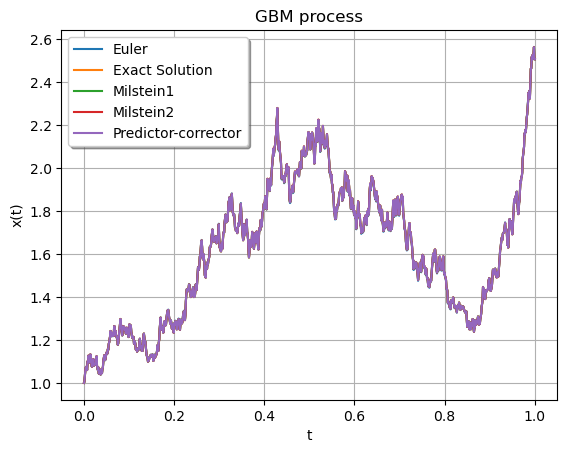

In [4]:
T = 1
Nx = 1
Nt = 1000

x0 = 1
init_state = x0 * np.ones(Nx)
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


In [5]:
T = 1
Nx = 1
x0 = 1
theta1 = 2
theta2 = 0.5
params = [theta1, theta2]
init_state = x0 * np.ones(Nx)

N_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]

max_diffs = {
    'Euler': [],
    'Milstein1': [],
    'Milstein2': [],
    'PredictorCorrector': []
}

for Nt in N_values:
    dt = T / Nt
    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)

    BSMp = BSMprocess(params, T, Nx, Nt, init_state)

    t_data, exact_solution = BSMp.ExactSolution(dwt)

    t_data, euler_solution = BSMp.EulerSolution(dwt)
    t_data, milstein1_solution = BSMp.Milstein1Solution(dwt)
    t_data, milstein2_solution = BSMp.Milstein2Solution(dwt)
    t_data, predictor_corrector_solution = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)

    max_diffs['Euler'].append(np.max(np.abs(euler_solution - exact_solution)))
    max_diffs['Milstein1'].append(np.max(np.abs(milstein1_solution - exact_solution)))
    max_diffs['Milstein2'].append(np.max(np.abs(milstein2_solution - exact_solution)))
    max_diffs['PredictorCorrector'].append(np.max(np.abs(predictor_corrector_solution - exact_solution)))

pd.DataFrame(max_diffs, index=N_values)

,Euler,Milstein1,Milstein2,PredictorCorrector
2,0.958735,1.052879,0.104923,0.198142
4,3.016760,3.179059,0.456982,0.632057
8,1.969186,2.000750,0.176237,0.292247
128,0.110777,0.148353,0.003711,0.012495
256,0.281777,0.112629,0.000451,0.006291
512,0.030933,0.050301,0.000538,0.003338
1024,0.040860,0.005011,0.000094,0.000472
8192,0.005972,0.000307,0.000015,0.000045
16384,0.048764,0.004871,0.000046,0.000274
32768,0.005007,0.000440,0.000007,0.000022


Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



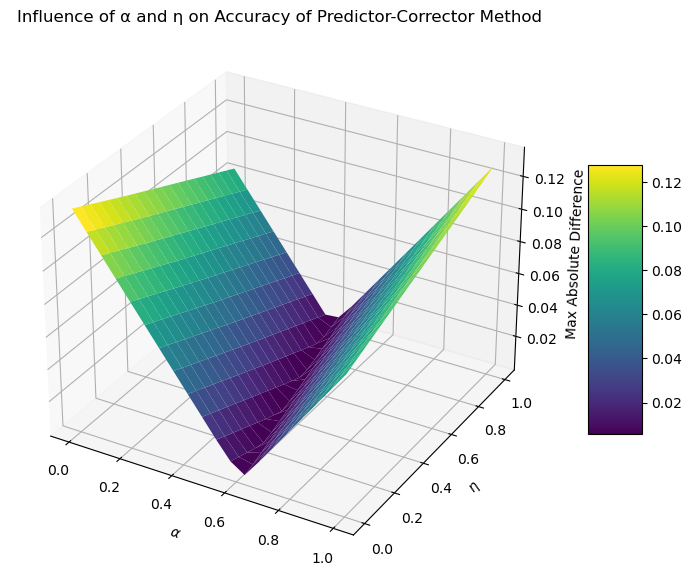

In [6]:
T = 1
Nx = 1
Nt = 1000
x0 = 1
theta1 = 2
theta2 = 0.5
params = [theta1, theta2]
init_state = x0 * np.ones(Nx)

dt = T / Nt
dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)

BSMp = BSMprocess(params, T, Nx, Nt, init_state)

_, exact_solution = BSMp.ExactSolution(dwt)

alpha_values = np.linspace(0, 1, 20)
eta_values = np.linspace(0, 1, 20)

errors = np.zeros((len(alpha_values), len(eta_values)))

for i, alpha in enumerate(alpha_values):
    for j, eta in enumerate(eta_values):
        _, predictor_corrector_solution = BSMp.PredictorCorrectorSolution(dwt, alpha, eta)
        max_diff = np.max(np.abs(predictor_corrector_solution - exact_solution))
        errors[i, j] = max_diff

alpha_grid, eta_grid = np.meshgrid(alpha_values, eta_values)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(alpha_grid, eta_grid, errors.T, cmap='viridis')

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\eta$')
ax.set_zlabel('Max Absolute Difference')
ax.set_title('Influence of α and η on Accuracy of Predictor-Corrector Method')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

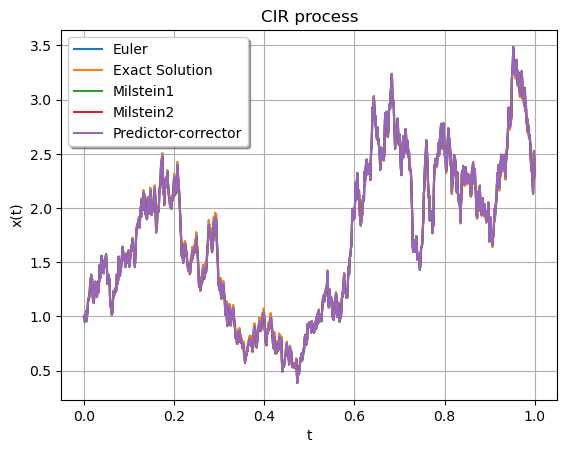

In [7]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

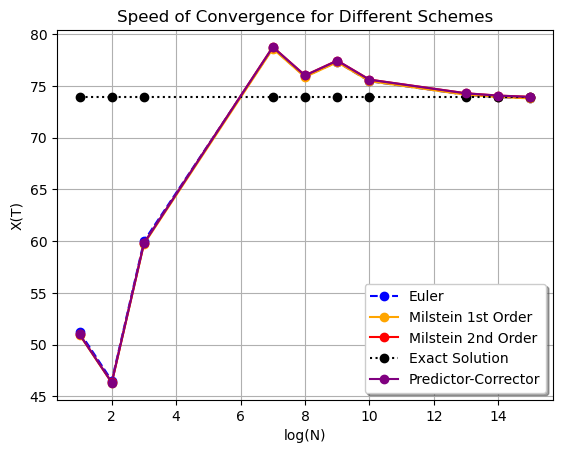

In [81]:
T = 1
Nt = 1000
x0 = 10
params = [2, 0.5]
N_values = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]

log_N = []
X_euler = []
X_milstein1 = []
X_milstein2 = []
X_predictor_corrector = []
X_exact = []

np.random.seed(0)
dt = T / Nt
Nx = N_values[-1]
dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)
BSMprocess(params, T, Nx, Nt, init_state=x0 * np.ones(Nx))
X_exact_sol = BSMp.ExactSolution(dwt)[1][-1].mean()


for Nx in N_values:
    np.random.seed(0)
    dt = T / Nt
    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)
    
    log_N.append(np.log2(Nx))
    
    BSMp = BSMprocess(params, T, Nx, Nt, init_state=x0 * np.ones(Nx))
    
    X_exact.append(X_exact_sol)
    X_euler.append(BSMp.EulerSolution(dwt)[1][-1].mean())
    X_milstein1.append(BSMp.Milstein1Solution(dwt)[1][-1].mean())
    X_milstein2.append(BSMp.Milstein2Solution(dwt)[1][-1].mean())
    X_predictor_corrector.append(BSMp.PredictorCorrectorSolution(dwt, alpha=0.5, eta=0.5)[1][-1].mean())

plt.plot(log_N, X_euler, label="Euler", marker='o', linestyle='--', color='blue')
plt.plot(log_N, X_milstein1, label="Milstein 1st Order", marker='o', linestyle='-', color='orange')
plt.plot(log_N, X_milstein2, label="Milstein 2nd Order", marker='o', linestyle='-', color='red')
plt.plot(log_N, X_exact, label="Exact Solution", marker='o', linestyle='dotted', color='black')
plt.plot(log_N, X_predictor_corrector, label="Predictor-Corrector", marker='o', linestyle='-', color='purple')

plt.xlabel("log(N)")
plt.ylabel("X(T)")
plt.title("Speed of Convergence for Different Schemes")
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()


Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [21]:
Nx = 100
Nt = 1000

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

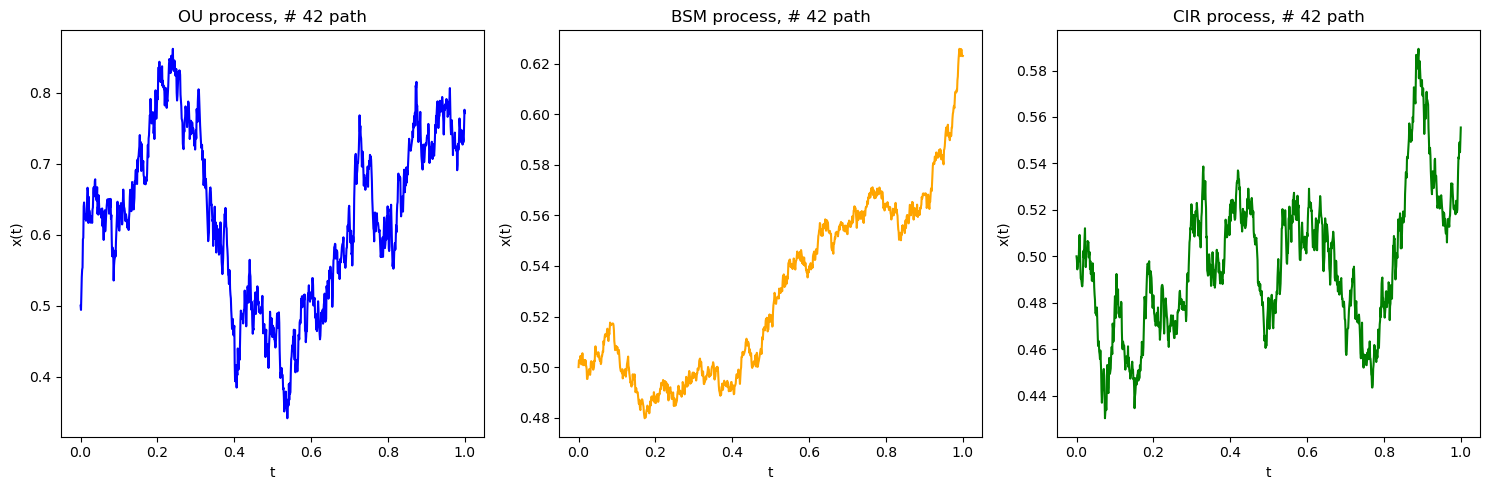

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

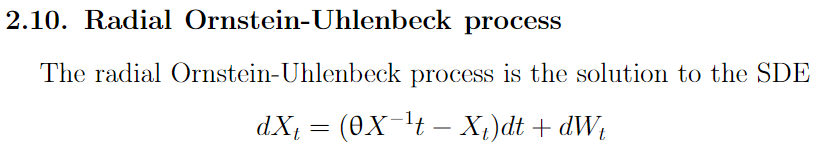

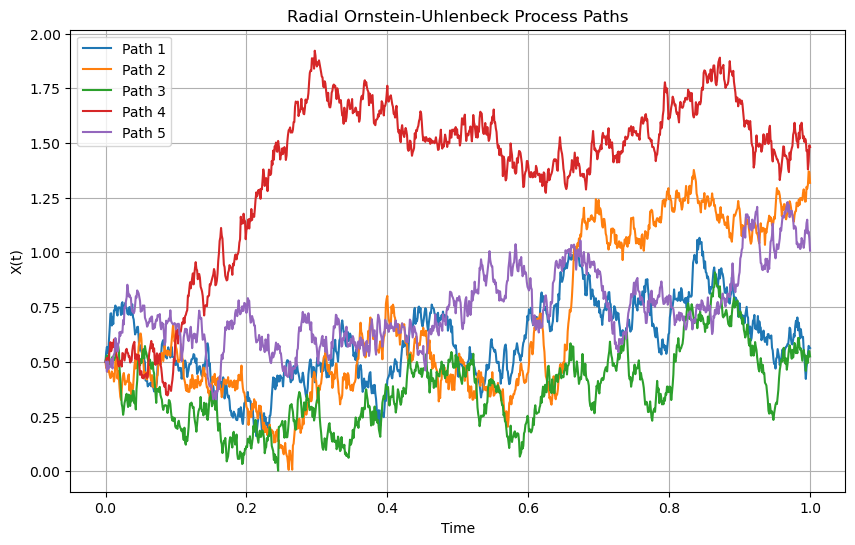

In [18]:
class ROU_Process(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):

        super().__init__(params, T, Nx, Nt, init_state)
        self.bxt = lambda x: self.params[0] / np.maximum(x, 1e-6) - x
        self.sigmaxt = lambda x: 1
    
    def DefaultInitState(self):
        return np.ones(self.Nx) * (self.init_state if self.init_state is not None else 0.5)

    def SampleFromDensity(self, x0, t, t0):
        dt = t - t0
        drift = self.bxt(x0) * dt
        diffusion = self.sigmaxt(x0) * np.random.normal(0, np.sqrt(dt), size=self.Nx)
        return x0 + drift + diffusion

    def PathGenerator(self):
        # dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state


        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        
        return t_data, x_data


T = 1
Nx = 5
Nt = 1000
theta = 0.5
params = [theta]
init_state = 0.5

rou_process = ROU_Process(params, T, Nx, Nt, init_state=init_state)
t_data, paths = rou_process.PathGenerator()

plt.figure(figsize=(10, 6))
for i in range(Nx):
    plt.plot(t_data, paths[:, i], label=f'Path {i+1}')
plt.title("Radial Ornstein-Uhlenbeck Process Paths")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.grid(True)
plt.show()


Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [23]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

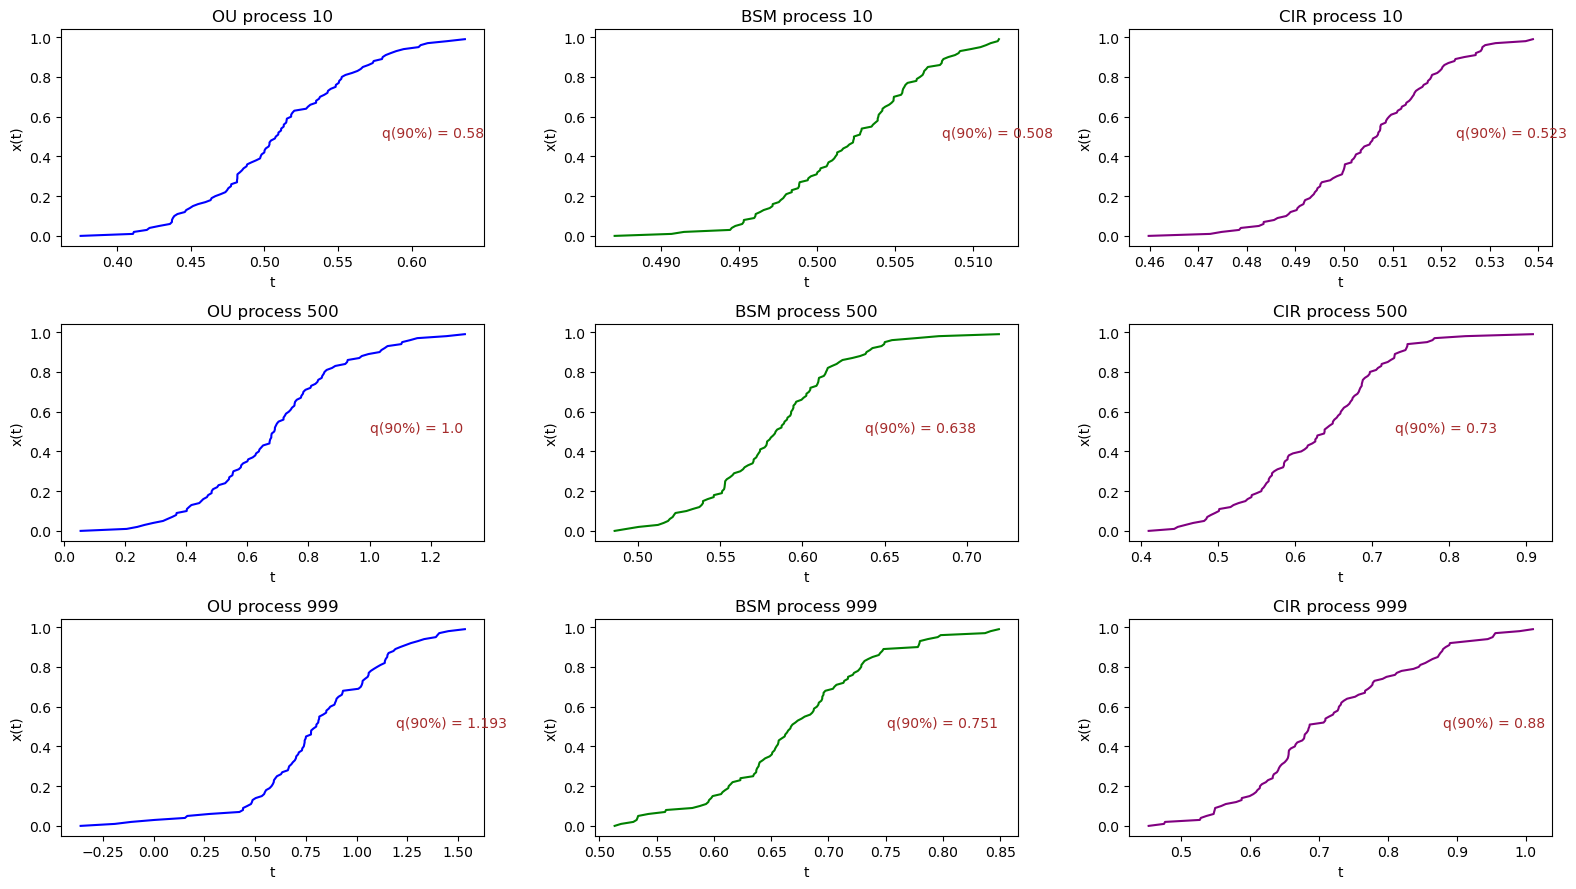

In [24]:
#cdf function and 90% quantile

#distributions become more widely and change with time

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    


OU process KS Test between start and end time points:
KS Statistic: 0.500, p-value: 0.000

BSM process KS Test between start and end time points:
KS Statistic: 0.930, p-value: 0.000

CIR process KS Test between start and end time points:
KS Statistic: 0.780, p-value: 0.000


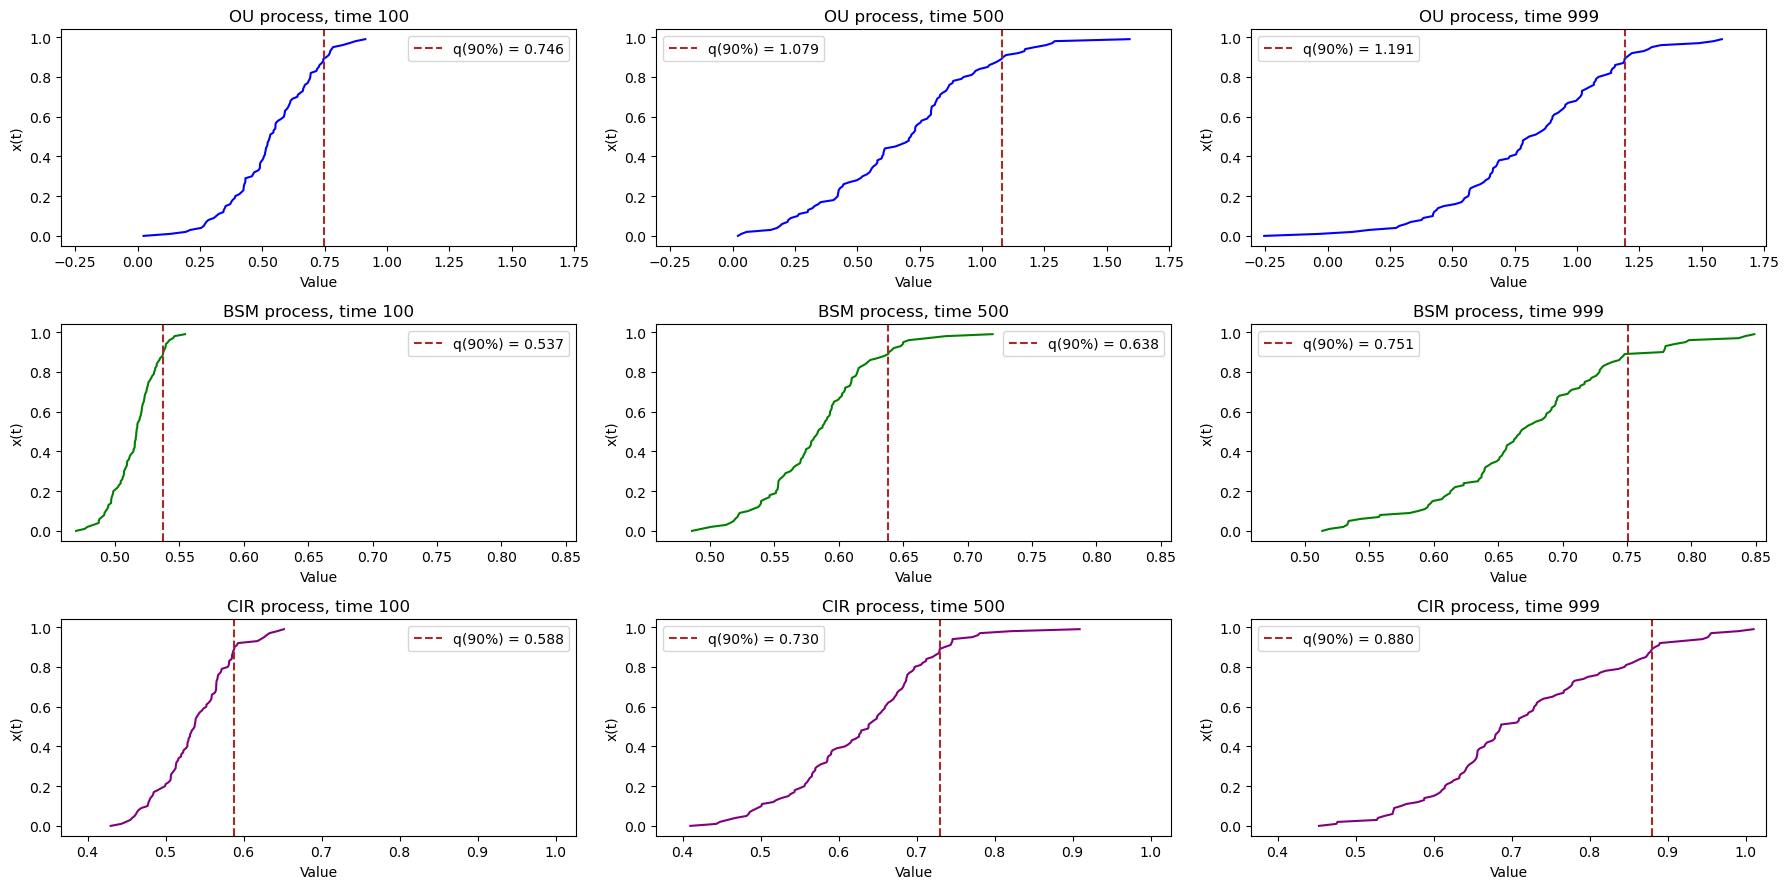

In [89]:
from scipy.stats import ks_2samp

def perform_ks_test(sample1, sample2):
    ks_stat, p_value = ks_2samp(sample1, sample2)
    print(f"KS Statistic: {ks_stat:.3f}, p-value: {p_value:.3f}")
    return ks_stat, p_value


fig, axs = plt.subplots(3, 3, figsize=(18, 9))

n_start = 100
n_middle = Nt // 2
n_end = Nt - 1
time_points = [n_start, n_middle, n_end]


def plot_process(ax, data, process_name, color):
    x_min, x_max = data.min(), data.max()
    for i, n in enumerate(time_points):
        x, y = ecdf(data[n])
        ax[i].plot(x, y, color=color)
        val = np.quantile(data[n], 0.9)
        ax[i].axvline(val, color='brown', linestyle='--', label=f"q(90%) = {val:.3f}")
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_title(f'{process_name} process, time {n}')
        ax[i].set_xlabel("Value")
        ax[i].set_ylabel("x(t)")
        ax[i].legend()

for row, (data, process_name, color) in enumerate(zip(
        [x_data_OU, x_data_BSM, x_data_CIR],
        ["OU", "BSM", "CIR"],
        ["blue", "green", "purple"])):
    
    plot_process(axs[row], data, process_name, color)
    
    print(f"\n{process_name} process KS Test between start and end time points:")
    perform_ks_test(data[n_start], data[n_end])

plt.tight_layout()
plt.show()


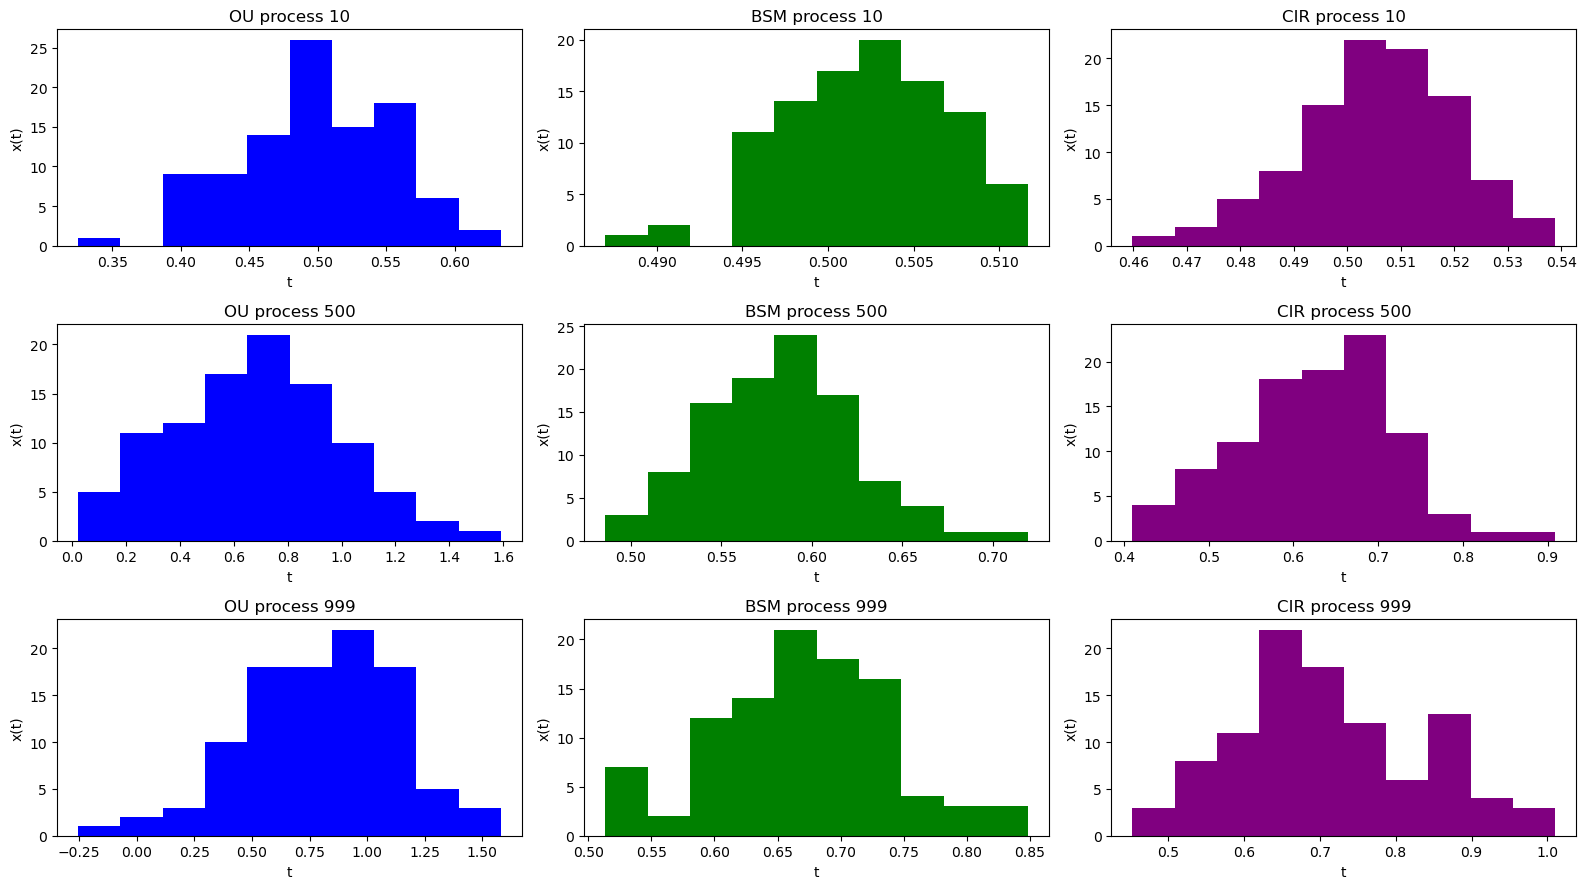

In [91]:
#density function

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        # axs[k][j].set_ylim(0, 350)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

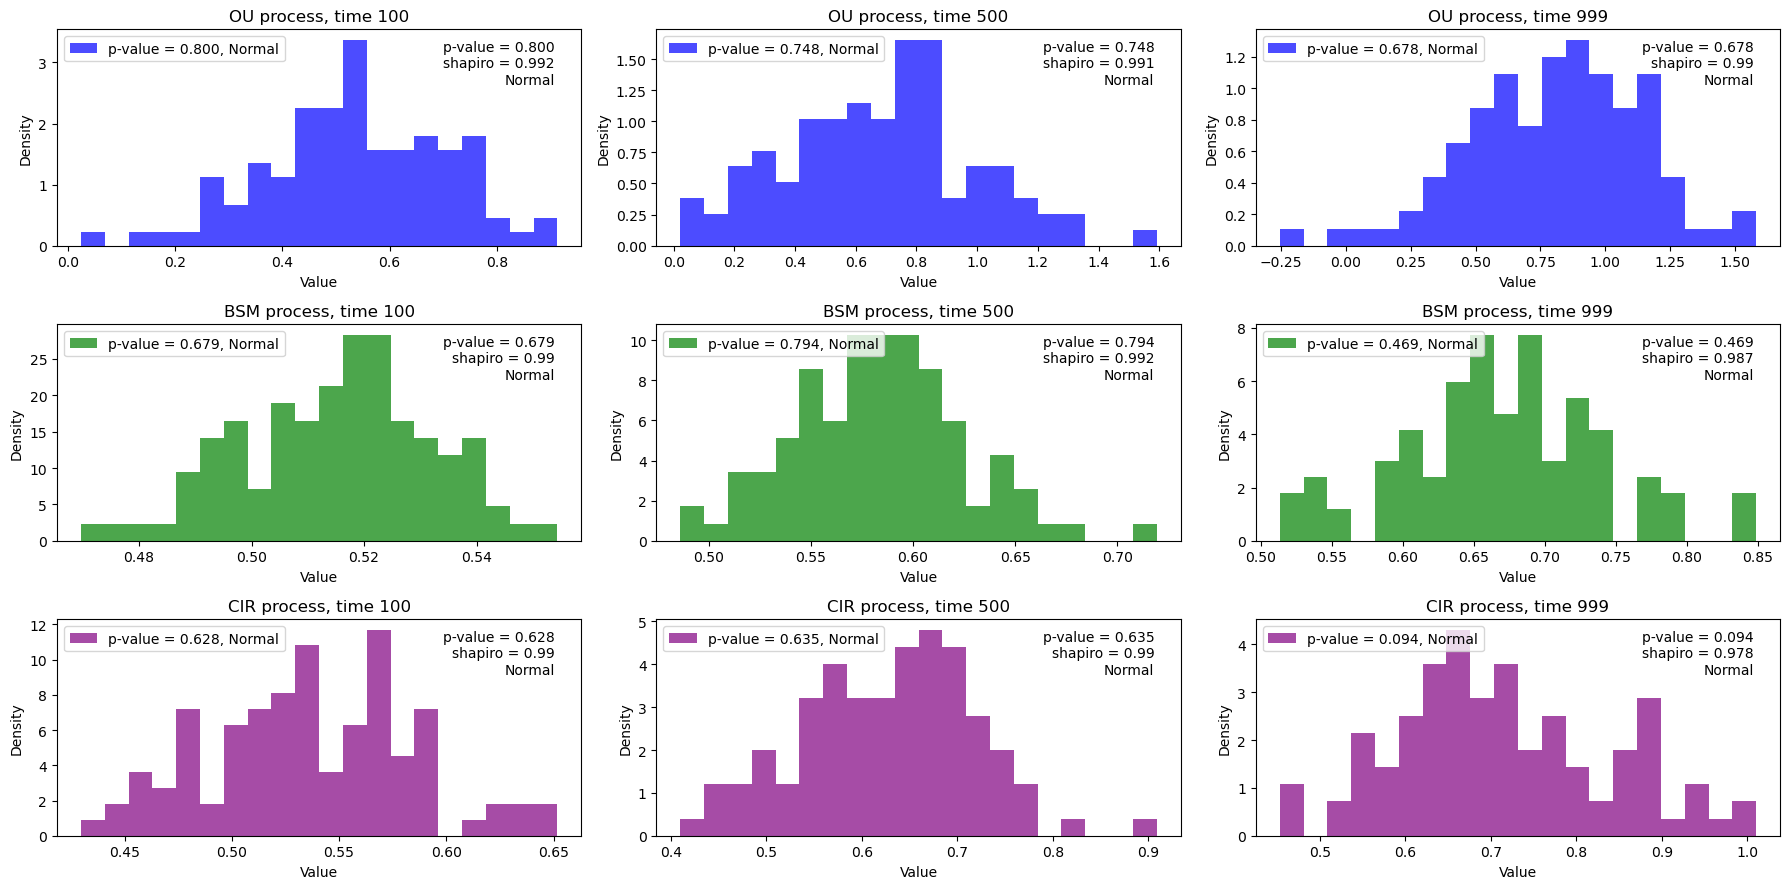

In [96]:
from scipy.stats import shapiro

fig, axs = plt.subplots(3, 3, figsize=(18, 9))

n_start = 100 
n_middle = Nt // 2
n_end = Nt - 1
time_points = [n_start, n_middle, n_end]

def plot_histogram_with_normality_test(ax, data, process_name, color):
    for i, n in enumerate(time_points):
        sample = data[n]
        
        ax[i].hist(sample, bins=20, color=color, alpha=0.7, density=True)
        ax[i].set_title(f'{process_name} process, time {n}')
        ax[i].set_xlabel("Value")
        ax[i].set_ylabel("Density")
        
        # Выполнение теста Шапиро-Уилка
        stat, p_value = shapiro(sample)
        
        conclusion = "Normal" if p_value > 0.05 else "Not normal"
        ax[i].text(0.95, 0.95, f"p-value = {p_value:.3f}\nshapiro = {round(stat, 3)}\n{conclusion}", 
                   ha='right', va='top', transform=ax[i].transAxes, color='black')
        ax[i].legend([f"p-value = {p_value:.3f}, {conclusion}"], loc='upper left')


for row, (data, process_name, color) in enumerate(zip(
        [x_data_OU, x_data_BSM, x_data_CIR],
        ["OU", "BSM", "CIR"],
        ["blue", "green", "purple"])):
    
    plot_histogram_with_normality_test(axs[row], data, process_name, color)

plt.tight_layout()
plt.show()
